In [1]:
!pip install --user --upgrade tensorflow-probability
!pip install observations

    100% |████████████████████████████████| 460kB 6.1MB/s 
    100% |████████████████████████████████| 491kB 5.2MB/s 
  Running setup.py bdist_wheel for observations ... - \ | / - \ | / - \ | / done
  Stored in directory: /content/.cache/pip/wheels/21/53/d7/c4d7a5cab86d07b083ebb2e417dcd0cb2bf5dd8c440af675d7
Successfully built observations


In [0]:
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed

from observations import iris, mnist
DATA_DIR = './data'


%matplotlib inline

seed = 2018
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist(DATA_DIR)
N = 1999
x_train = x_train[:N].T
y_class = y_train[:N]
print(x_train.shape, len(y_class))

data_dim, num_datapoints = x_train.shape
latent_dim = 2
stddv_datapoints = 0.5

>> Downloading ./data/train-images-idx3-ubyte.gz.part 
>> [9.5 MB/9.5 MB] 105% @122.4 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz downloaded to ./data/train-images-idx3-ubyte.gz 


/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 55860), raddr=('74.125.124.128', 443)>
  download_file(url, filepath, hash_true, resume)


>> Downloading ./data/train-labels-idx1-ubyte.gz.part 
>> [28.2 KB/28.2 KB] 3630% @82.6 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz downloaded to ./data/train-labels-idx1-ubyte.gz 
>> Downloading ./data/t10k-images-idx3-ubyte.gz.part 
>> [1.6 MB/1.6 MB] 127% @69.2 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz downloaded to ./data/t10k-images-idx3-ubyte.gz 
>> Downloading ./data/t10k-labels-idx1-ubyte.gz.part 
>> [4.4 KB/4.4 KB] 23086% @79.7 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz downloaded to ./data/t10k-labels-idx1-ubyte.gz 


/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 55866), raddr=('74.125.124.128', 443)>
  download_file(url, filepath, hash_true, resume)
/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 55872), raddr=('74.125.124.128', 443)>
  download_file(url, filepath, hash_true, resume)
/usr/local/lib/python3.6/dist-packages/observations/util.py:601: ResourceWarning: unclosed <ssl.SSLSocket fd=64, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 38604), raddr=('209.85.147.128', 443)>
  download_file(url, filepath, hash_true, resume)


(784, 1999) 1999


In [0]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddv_datapoints, n_fixed, zf):
    print('PPCA MODEL: ', data_dim, latent_dim, num_datapoints, stddv_datapoints, n_fixed)
  
    zd = ed.Normal(
        loc=tf.zeros([latent_dim, (num_datapoints - n_fixed)]),
        scale=tf.ones([latent_dim, (num_datapoints - n_fixed)]),
        name='zd'
    )
    
    w = ed.Normal(
        loc=tf.zeros([data_dim, latent_dim]),
        scale=tf.ones([data_dim, latent_dim]),
        name='w'
    )
    
    x = ed.Normal(
        loc=tf.concat([tf.matmul(w,zd),tf.matmul(w,zf)], axis=1),
        scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
        name='x'
    )
    
    return x, (w, zd)

In [0]:
# for the first term: define an energy function
def energy_func(x_train, qw, qzd, zf, n_fixed=0):
    log_joint_ppca_model = ed.make_log_joint_fn(ppca_model)      
    return log_joint_ppca_model(
        data_dim=data_dim, latent_dim=latent_dim,
        num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints,
        n_fixed=n_fixed,
        x=x_train, w=qw, zd=qzd, zf=zf
    )

In [0]:
# for the second term:
# first, define the variational model of two variable W and Z
def variational_model(qw_mean, qw_stddv, qzd_mean, qzd_stddv):
    qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name='qw')
    qzd = ed.Normal(loc=qzd_mean, scale=qzd_stddv, name='qzd')
    return qw, qzd

In [0]:
# finally, define the entropy function
def entropy_func(qw, qzd, qw_mean, qw_stddv, qzd_mean, qzd_stddv):
    log_joint_variational_model = ed.make_log_joint_fn(variational_model)
    
    return - log_joint_variational_model(
        qw_mean=qw_mean, qw_stddv=qw_stddv, qzd_mean=qzd_mean, qzd_stddv=qzd_stddv,
        qw=qw, qzd=qzd
    )

In [0]:
def train(x_train, num_epochs = 1000, list_fixed=[]):
    # because we've run the computational graph of TF once,
    # before continuing to run the TF code, we MUST reset the computational graph
    tf.reset_default_graph()
    
    n_fixed = len(list_fixed)
    print('Fixed point: ', n_fixed)
    
    # define the variables for W and Z (note to specify the default values for them)
    qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
    qzd_mean = tf.Variable(np.ones([latent_dim, num_datapoints - n_fixed]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
    qzd_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints - n_fixed]), dtype=tf.float32))
    

    # once we have the `variational_model`
    # use this model to specify the variational variables `qw` and `qz`
    qw, qzd = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qzd_mean=qzd_mean, qzd_stddv=qzd_stddv)

    # create fixe dist. for list_fixed points
    if n_fixed == 0:
      zf = ed.Normal(
          loc=tf.zeros([latent_dim, n_fixed]),
          scale=tf.ones([latent_dim, n_fixed]),
          name='zf'
      )
    else:
      zf = ed.Normal(
          loc=list_fixed.T,
          scale=0.1,
          name='zf'
      )
    
    # define how to calculate the energy and entropy
    energy = energy_func(x_train, qw, qzd, zf, n_fixed)
    entropy = entropy_func(qw, qzd, qw_mean, qw_stddv, qzd_mean, qzd_stddv)

    # define an ELBO objective function
    elbo = energy + entropy # TODO: should take opposite of elbo here

    # define how to maximize the ELBO (or minimize -elbo)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
    train_process = optimizer.minimize( - elbo)

    init_process = tf.global_variables_initializer()
    losses = []

    with tf.Session() as sess:
        # first, make sure to init all varaibles
        sess.run(init_process)

        # then run the training process
        for i in range(num_epochs):
            sess.run(train_process)

            # log the value of ELBO objective function
            if i % 5 == 0:
                loss = sess.run([elbo])
                losses.append(loss)

        # after finishing the training, make sure to collect the target parameters
        w_mean_vi = sess.run(qw_mean)
        w_stddv_vi = sess.run(qw_stddv)
        zd_mean_vi = sess.run(qzd_mean)
        zd_stddv_vi = sess.run(qzd_stddv)
        
    return losses, (w_mean_vi, w_stddv_vi), (zd_mean_vi, zd_stddv_vi)

In [0]:
from matplotlib import cm
from matplotlib import patches


def viz(z_mean_vi, z_stddv_vi, y_class, num_datapoints, list_fixed):
    n_fixed = len(list_fixed)
    
    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(z_mean_vi[0, :], z_mean_vi[1, :], s=4, c=y_class[:num_datapoints-n_fixed], cmap=cm.tab10, alpha=1.0)

    # draw ellipse
    for i in range(num_datapoints):
      if i < num_datapoints - n_fixed:
        x_center, y_center = z_mean_vi[0, i], z_mean_vi[1, i]
        width, height = z_stddv_vi[0, i], z_stddv_vi[1, i]
      else:
        x_center, y_center = list_fixed[num_datapoints-i-1, 0], list_fixed[num_datapoints-i-1, 1]
        width, height = 0.1, 0.1
        ax.plot([x_center], [y_center], marker='*', markersize=20, color='red')
        
      e = patches.Ellipse((x_center, y_center), width * 30, height * 30)
      e.set_alpha(0.2)
      e.set_facecolor(cm.tab10(y_class[i]))
      ax.add_artist(e)

    plt.show()
    

    
def viz_diff(z_mean0, z_mean1, y_class, num_datapoints, list_fixed0, list_fixed1):
    # print(z_mean0.shape, z_mean1.shape, list_fixed0, list_fixed1)
    
    n_fixed = len(list_fixed0)
    fig, ax = plt.subplots(figsize=(12,12))
    plt.axis([-5, 22, -5, 22])

    for i in range(num_datapoints - n_fixed):
        x1, y1 = z_mean0[:, i]
        x2, y2 = z_mean1[:, i]
        ax.arrow(x1, y1, x2-x1, y2-y1, color=cm.tab10(y_class[i]), shape='full', lw=0.8, length_includes_head=True, head_width=.1)
      
    for j in range(n_fixed):
        x1, y1 = list_fixed0[j]
        x2, y2 = list_fixed1[j]
        j_class = y_class[num_datapoints - n_fixed + j]
        print("Move point {} (class {} ) from {} to {}".format(j+1, j_class, (x1, y1), (x2, y2)))
        
        ax.arrow(x1, y1, x2-x1, y2-y1, color=cm.tab10(j_class), shape='full', lw=0.8, length_includes_head=True, head_width=.1)
        ax.plot([x2], [y2], marker='*', markersize=20, color=cm.tab10(j_class))

    plt.show()    

Fixed point:  0


/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)
/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)


PPCA MODEL:  784 2 1999 0.5 0


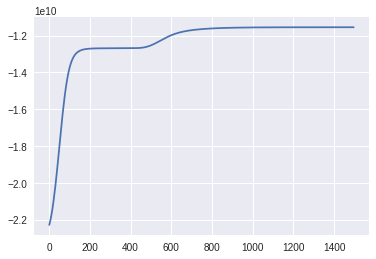

In [13]:
num_epochs = 1500
losses, (w_mean_vi, w_stddv_vi), (z_mean0, z_stddv0) = train(x_train, num_epochs, list_fixed=[])

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

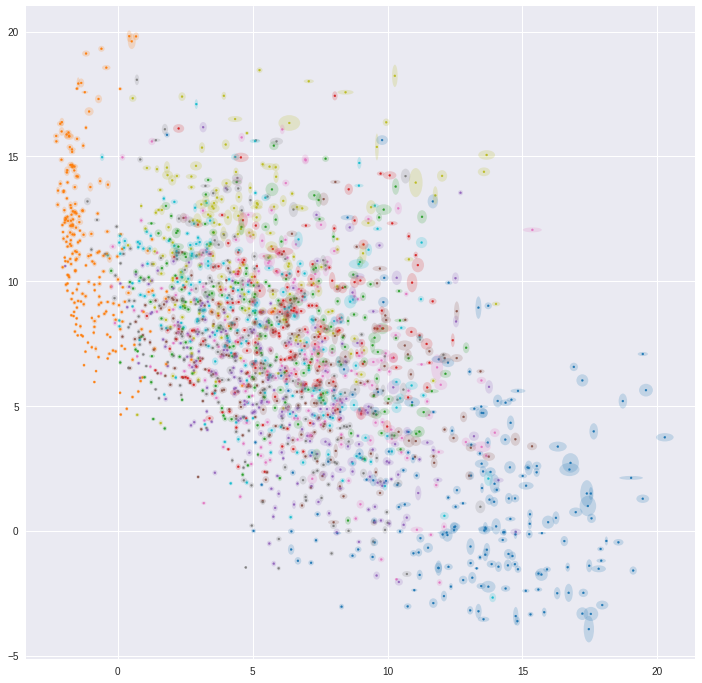

In [36]:
viz(z_mean0, z_stddv0, y_class, num_datapoints, list_fixed=[])

Fixed point:  2
PPCA MODEL:  784 2 1999 0.5 2


/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)
/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)


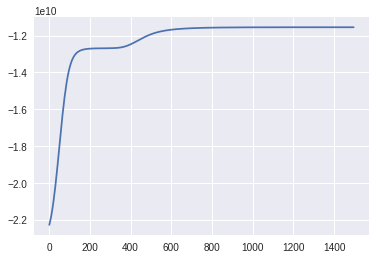

In [26]:
num_epochs = 1500
list_fixed1=np.array([ [10., 5.], [5., 10.] ], dtype=np.float32)
losses, (w_mean_vi, w_stddv_vi), (z_mean1, z_stddv1) = train(x_train, num_epochs, list_fixed1)

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

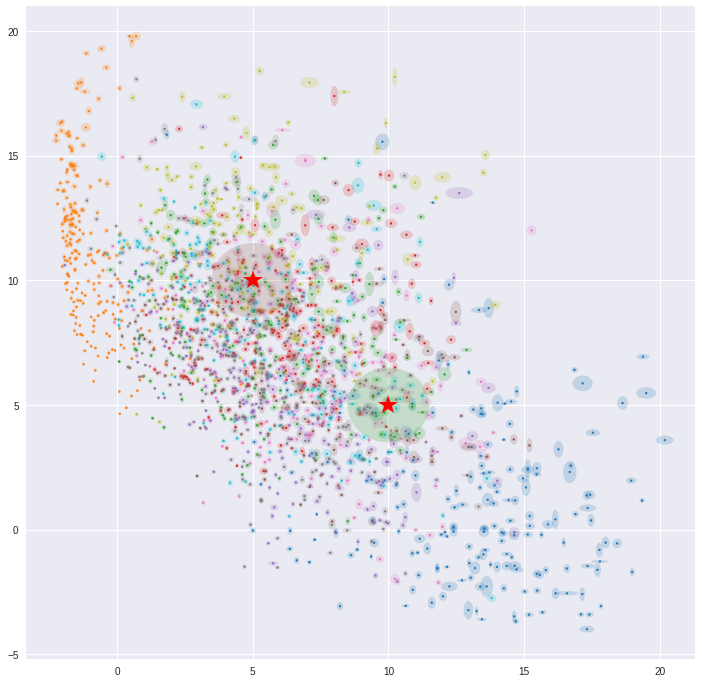

Move point 1 (class 5 ) from (13.443628311157227, 6.386723041534424) to (10.0, 5.0)
Move point 2 (class 2 ) from (2.244171142578125, 11.381531715393066) to (5.0, 10.0)


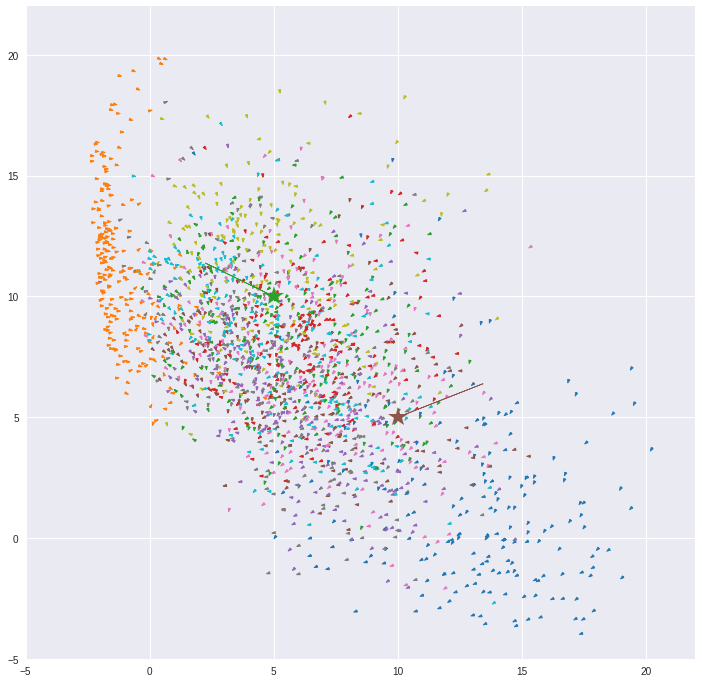

In [37]:
viz(z_mean1, z_stddv1, y_class, num_datapoints, list_fixed1)
list_fixed0 = z_mean0[:,-2:].T.tolist()
viz_diff(z_mean0, z_mean1, y_class, num_datapoints, list_fixed0, list_fixed1)

Fixed point:  2
PPCA MODEL:  784 2 1999 0.5 2


/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)
/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)


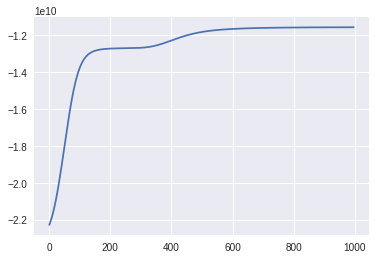

In [31]:
num_epochs = 1000
list_fixed2=np.array([ [15., 0.], [0., 15.] ], dtype=np.float32)
losses, (w_mean_vi, w_stddv_vi), (z_mean2, z_stddv2) = train(x_train, num_epochs, list_fixed2)

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

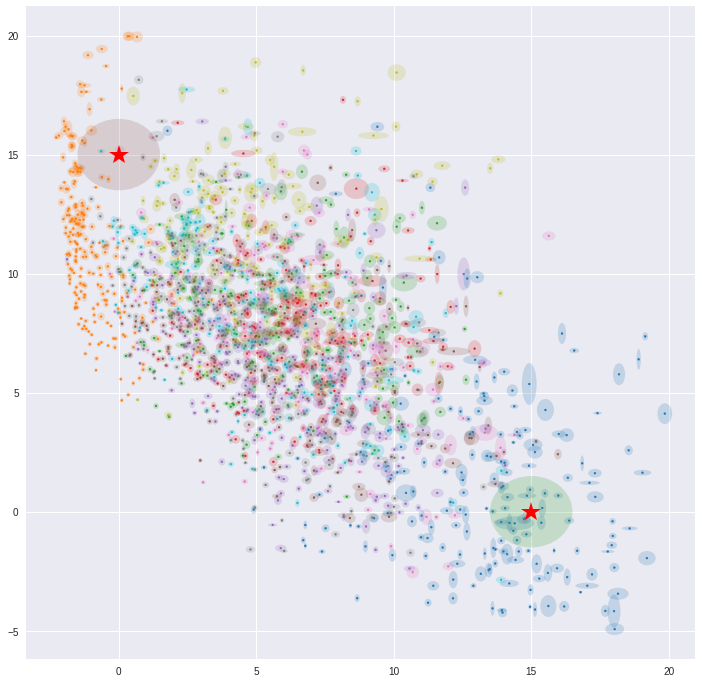

Move point 1 (class 5 ) from (13.443628311157227, 6.386723041534424) to (15.0, 0.0)
Move point 2 (class 2 ) from (2.244171142578125, 11.381531715393066) to (0.0, 15.0)


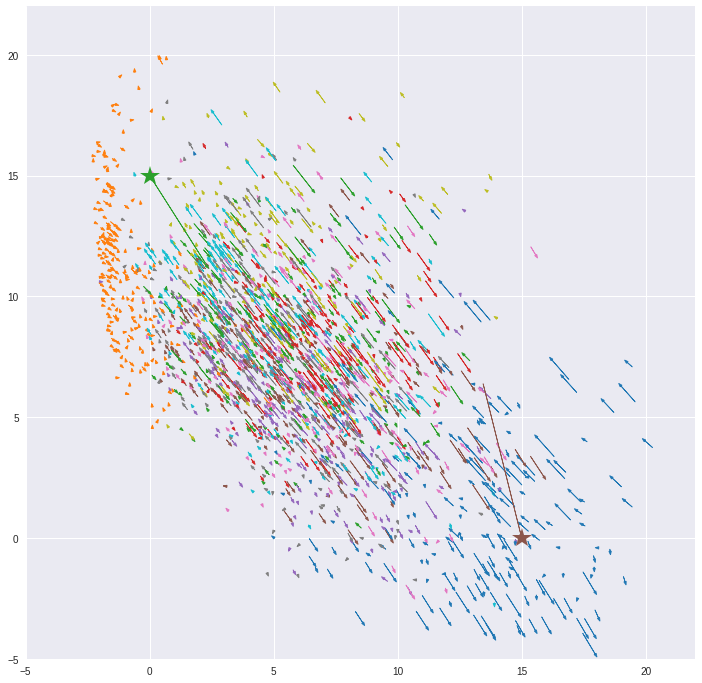

Move point 1 (class 5 ) from (10.0, 5.0) to (15.0, 0.0)
Move point 2 (class 2 ) from (5.0, 10.0) to (0.0, 15.0)


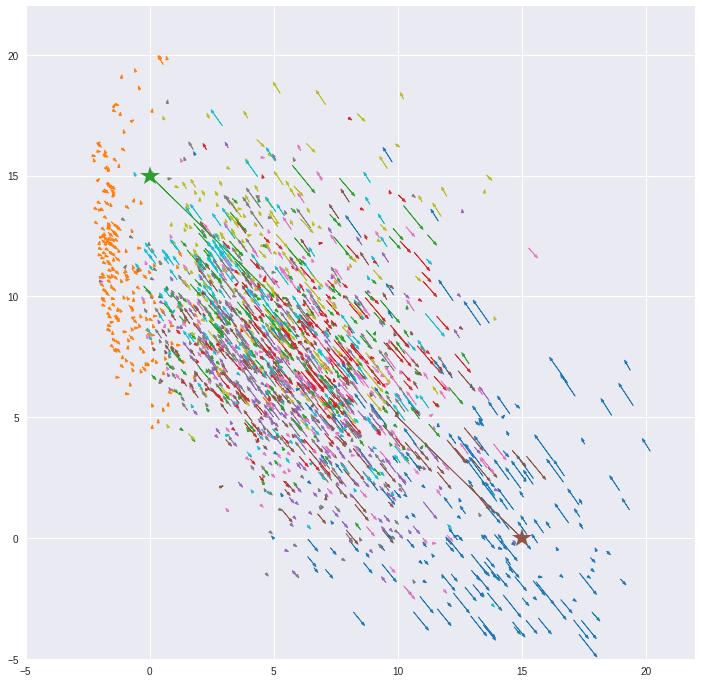

In [38]:
viz(z_mean2, z_stddv2, y_class, num_datapoints, list_fixed2)

viz_diff(z_mean0, z_mean2, y_class, num_datapoints, list_fixed0, list_fixed2)

viz_diff(z_mean1, z_mean2, y_class, num_datapoints, list_fixed1, list_fixed2)

In [0]:
def replace_latents(z_mean, z_stddv):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replaces the priors with the calculated priors"""
        name = rv_kwargs.pop("name")
        if name == "qzd":
          rv_kwargs["loc"] = z_mean
          rv_kwargs["scale"] = z_stddv
          print("QZD replaced: ", rv_kwargs)
        return rv_constructor(*rv_args, **rv_kwargs)
    return interceptor

Fixed point:  1
QZD replaced:  {'loc': array([[ 6.4569917, 12.79358  ,  5.7641993, ..., 17.4236   ,  5.6321115,
        13.443628 ],
       [ 7.8839107,  1.099634 ,  0.562197 , ...,  0.990358 ,  3.8422248,
         6.386723 ]], dtype=float32), 'scale': array([[0.0122085 , 0.00909176, 0.00483392, ..., 0.02045139, 0.00786505,
        0.01003294],
       [0.00573738, 0.00436781, 0.00859147, ..., 0.02737695, 0.00792644,
        0.00577022]], dtype=float32)}
PPCA MODEL:  784 2 1999 0.5 1


/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)
/content/.local/lib/python3.6/site-packages/tensorflow_probability/python/edward2/program_transformations.py:134: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argspec = inspect.getargspec(f)


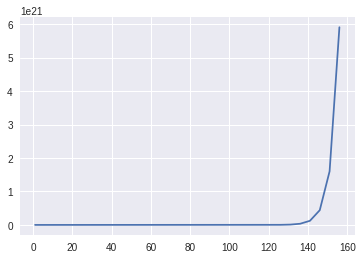

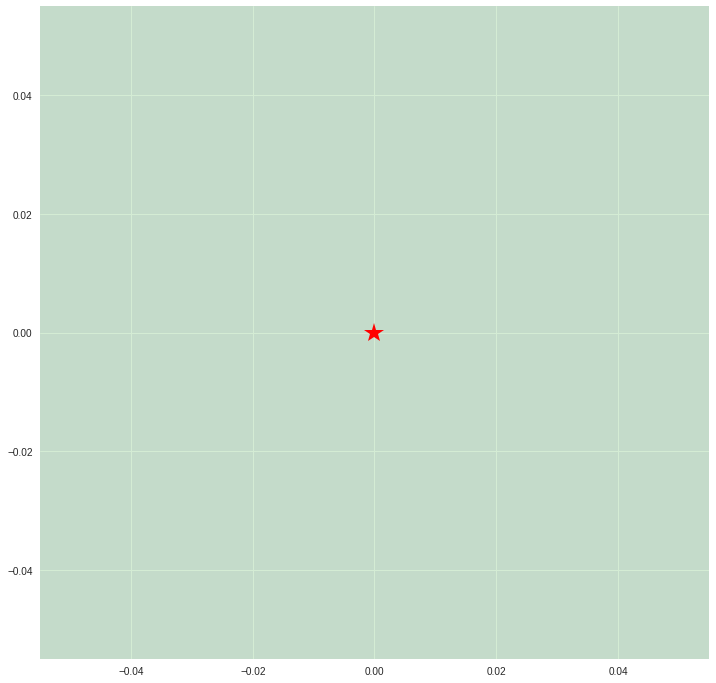

In [41]:
num_epochs = 1500
list_fixed4=np.array([ [0., 0.]], dtype=np.float32)
n_fixed = len(list_fixed4)
old_z_mean = z_mean0[:,:-n_fixed]    
old_z_stddv = z_stddv0[:, :-n_fixed]

with ed.interception(replace_latents(old_z_mean, old_z_stddv)):
    losses, (w_mean_vi, w_stddv_vi), (new_z_mean_vi, new_z_stddv_vi) = train(x_train, num_epochs, list_fixed4)

plt.plot(range(1, num_epochs, 5), losses)
plt.show()

viz(new_z_mean_vi, new_z_stddv_vi, y_class, num_datapoints, list_fixed4)

In [42]:
print(new_z_mean_vi)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
